# Task 4 – PV Cleaning and Imputation


## Setup

In [58]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL
from IPython.display import display

# === Path Configuration ===
ROOT = Path('..')
DATA_PATH = ROOT / 'data' / 'raw' / 'train_252145.csv'
FIGURES_DIR = ROOT / 'reports' / 'figures'
TABLES_DIR = ROOT / 'reports' / 'tables'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# === Color Palette ===
COLORS = {
    'pv_mod1': '#FFA500',
    'pv_mod2': '#2ca02c',
    'pv_mod3': '#1f77b4',
    'imputed_simple': '#E07A5F',
    'imputed_univariate': '#3D405B',
    'imputed_multivariate': '#81B29A',
}

# === Matplotlib Style Configuration ===
mpl.rcParams.update({
    'figure.dpi': 110,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.titlelocation': 'left',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'axes.grid': True,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '#dddddd',
})

sns.set_theme(style='whitegrid')


def save_figure(fig, basename, dpi=300):
    """Save figure as PNG only."""
    png_path = FIGURES_DIR / f'{basename}.png'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight')
    print(f"Saved: {png_path}")
    return png_path

## Load data

In [59]:
# Load dataset
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp')
df = df.set_index('timestamp')
PV_COLS = ['pv_mod1', 'pv_mod2', 'pv_mod3', 'pv']

print("Dataset Head:")
display(df.head())

Dataset Head:


,pv_mod1,pv_mod2,pv_mod3,Demand,pv,Price,Temperature,Pressure (hPa),Cloud_cover (%),Cloud_cover_low (%),Cloud_cover_mid (%),Cloud_cover_high (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),daymax
timestamp,,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4,0,0,3,10.5,NaN,0,0,0.0,3.56
2013-07-01 01:00:00+00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27,1,2,23,11.9,NaN,0,0,0.0,3.56
2013-07-01 02:00:00+00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33,0,0,32,11.6,NaN,0,0,0.0,3.56
2013-07-01 03:00:00+00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28,0,0,27,11.2,NaN,2,7,30.1,3.56
2013-07-01 04:00:00+00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16,0,1,14,11.7,NaN,30,31,252.0,3.56


In [60]:
# Calculate missingness statistics
missing_counts = df[PV_COLS].isna().sum()
missing_pct = df[PV_COLS].isna().mean() * 100
summary_missing = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_pct}).round(2)
summary_missing_path = TABLES_DIR / 'task4_missing_summary.csv'
summary_missing.to_csv(summary_missing_path)

print("Missingness Summary:")
display(summary_missing)

Missingness Summary:


,missing_count,missing_pct
pv_mod1,438,5.00
pv_mod2,491,5.61
pv_mod3,510,5.82
pv,0,0.00


In [61]:
# Analyze missing data runs
is_nan = df['pv_mod1'].isna()
run_lengths = []
current_start = None
for idx, (ts, val) in enumerate(is_nan.items()):
    if val and current_start is None:
        current_start = ts
    elif not val and current_start is not None:
        run_lengths.append({'start': current_start, 'end': ts, 'length': (ts - current_start).total_seconds() / 3600})
        current_start = None
if current_start is not None:
    run_lengths.append({'start': current_start, 'end': df.index[-1], 'length': (df.index[-1] - current_start).total_seconds() / 3600})

runs_df = pd.DataFrame(run_lengths)
if not runs_df.empty:
    runs_df['length_hours'] = runs_df['length']
    runs_df.drop(columns='length', inplace=True)
    runs_summary_path = TABLES_DIR / 'task4_missing_runs.csv'
    runs_df.to_csv(runs_summary_path, index=False)

print("Missing Data Runs (Head):")
display(runs_df.head())

Missing Data Runs (Head):


,start,end,length_hours
0,2013-07-03 04:00:00+00:00,2013-07-03 05:00:00+00:00,1.0
1,2013-07-04 21:00:00+00:00,2013-07-04 22:00:00+00:00,1.0
2,2013-07-06 02:00:00+00:00,2013-07-06 03:00:00+00:00,1.0
3,2013-07-08 02:00:00+00:00,2013-07-08 03:00:00+00:00,1.0
4,2013-07-10 05:00:00+00:00,2013-07-10 06:00:00+00:00,1.0


In [62]:
# Analyze missingness by time of day
df['hour'] = df.index.hour
time_of_day_missing = df.groupby('hour')['pv_mod1'].apply(lambda s: s.isna().mean() * 100)
tod_missing = time_of_day_missing.reset_index(name='% missing')
tod_missing_path = TABLES_DIR / 'task4_missing_tod.csv'
tod_missing.to_csv(tod_missing_path, index=False)

print("Missingness by Hour of Day:")
display(tod_missing)

Missingness by Hour of Day:


,hour,% missing
0,0,3.835616
1,1,4.931507
2,2,5.753425
3,3,3.835616
4,4,6.301370
5,5,4.931507
6,6,5.753425
7,7,7.123288
8,8,4.657534
9,9,4.657534


Saved: ../reports/figures/04_missing_by_hour.png


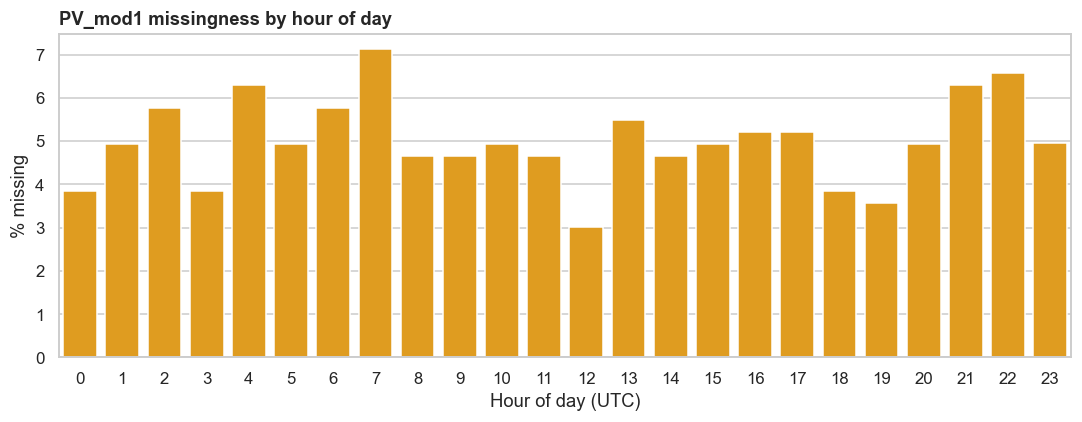

In [63]:
# Figure 1: Missingness by Hour of Day
# This helps identify if missing data is time-dependent (MNAR) or random (MCAR)
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=tod_missing, x='hour', y='% missing', color=COLORS['pv_mod1'], ax=ax)
ax.set_title('PV_mod1 missingness by hour of day')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('% missing')
fig.tight_layout()

save_figure(fig, '04_missing_by_hour')
plt.show()

Saved: ../reports/figures/04_missing_visualization.png


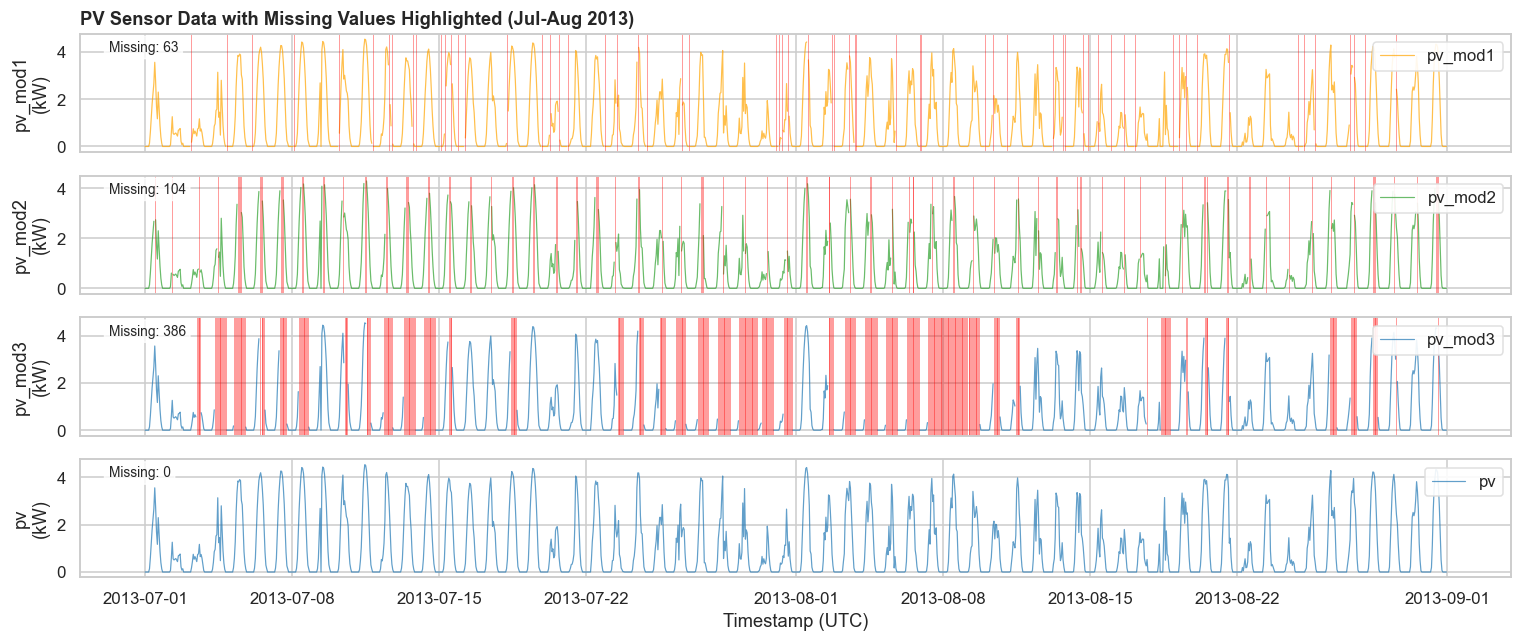

In [64]:
# Figure 2: Missing Data Visualization - Binary Indicator Plot
# This shows exactly when and where missing values occur across all PV sensors
# More readable than a heatmap for sparse missing data

# Create a subset for better visualization (e.g., first 2 months)
subset_start = '2013-07-01'
subset_end = '2013-08-31'
subset = df.loc[subset_start:subset_end, PV_COLS]

fig, axes = plt.subplots(len(PV_COLS), 1, figsize=(14, 6), sharex=True)

for i, col in enumerate(PV_COLS):
    # Plot actual values
    axes[i].plot(subset.index, subset[col], color=COLORS.get(col, '#1f77b4'), 
                 linewidth=0.8, alpha=0.7, label=col)
    
    # Mark missing values with red vertical lines
    missing_idx = subset[subset[col].isna()].index
    for idx in missing_idx:
        axes[i].axvline(x=idx, color='red', alpha=0.5, linewidth=0.5)
    
    axes[i].set_ylabel(f'{col}\n(kW)')
    axes[i].legend(loc='upper right')
    
    # Add count of missing values
    n_missing = len(missing_idx)
    axes[i].text(0.02, 0.85, f'Missing: {n_missing}', transform=axes[i].transAxes, 
                 fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[-1].set_xlabel('Timestamp (UTC)')
axes[0].set_title('PV Sensor Data with Missing Values Highlighted (Jul-Aug 2013)')

fig.tight_layout()

# Save with correct naming convention
save_figure(fig, '04_missing_visualization')
plt.show()

## Imputation strategies

In [65]:
# Apply imputation strategies
original = df['pv_mod1']
# Simple interpolation (time-based)
simple_imputed = original.interpolate(method='time')

# STL-based seasonal interpolation
stl = STL(original, period=24, robust=True)
stl_result = stl.fit()
seasonal = stl_result.seasonal
trend = stl_result.trend
resid = original - seasonal - trend
resid_interp = resid.interpolate(method='time')
univariate_imputed = seasonal + trend + resid_interp

# Multivariate KNN imputation
features = df[['pv_mod2', 'pv_mod3', 'Shortwave_radiation (W/m²)', 'Temperature']].copy()
features['pv_mod1'] = original
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
imputed_array = knn_imputer.fit_transform(features)
multivariate_imputed = pd.Series(imputed_array[:, -1], index=original.index, name='pv_mod1_knn')

imputed_df = pd.DataFrame({
    'original': original,
    'simple': simple_imputed,
    'univariate': univariate_imputed,
    'multivariate': multivariate_imputed,
})

print("Imputed Data Comparison (Head):")
display(imputed_df.head())

Imputed Data Comparison (Head):


,original,simple,univariate,multivariate
timestamp,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 01:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 02:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 03:00:00+00:00,0.0,0.0,NaN,0.0
2013-07-01 04:00:00+00:00,0.0,0.0,NaN,0.0


## Figure 3 – Imputation Method Comparison (Representative Days)

Saved: ../reports/figures/04_imputation_overlay.png


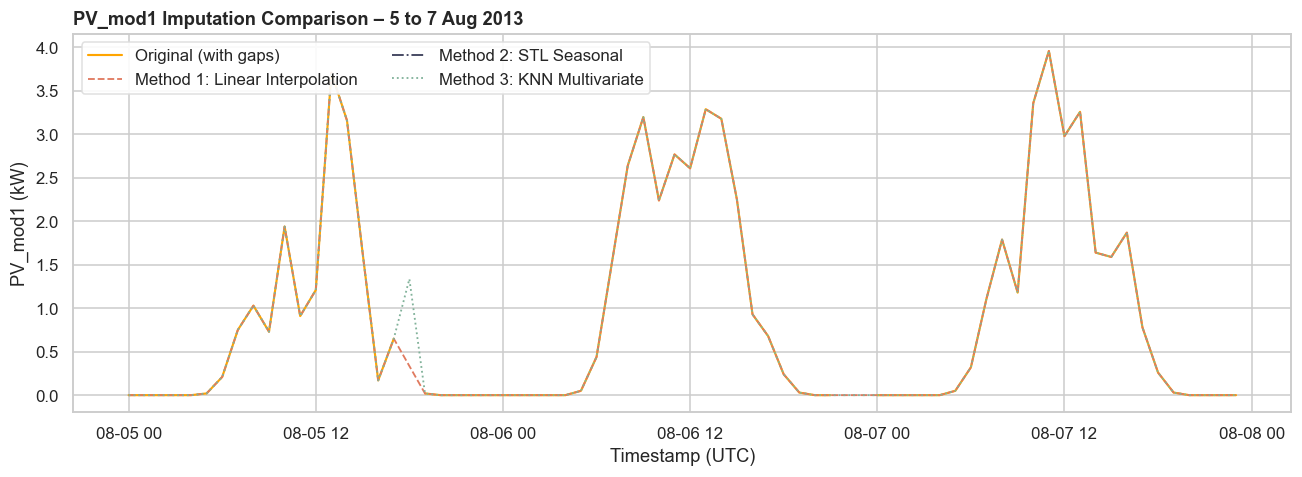

In [66]:
# Figure 3: Imputation Comparison on Representative Days
# Compare the three imputation methods on a sample window with known missing values
sample_window = imputed_df.loc['2013-08-05':'2013-08-07']

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(sample_window.index, sample_window['original'], label='Original (with gaps)', 
        color=COLORS['pv_mod1'], linewidth=1.4)
ax.plot(sample_window.index, sample_window['simple'], label='Method 1: Linear Interpolation', 
        color=COLORS['imputed_simple'], linewidth=1.2, linestyle='--')
ax.plot(sample_window.index, sample_window['univariate'], label='Method 2: STL Seasonal', 
        color=COLORS['imputed_univariate'], linewidth=1.2, linestyle='-.')
ax.plot(sample_window.index, sample_window['multivariate'], label='Method 3: KNN Multivariate', 
        color=COLORS['imputed_multivariate'], linewidth=1.2, linestyle=':')

ax.set_title('PV_mod1 Imputation Comparison – 5 to 7 Aug 2013')
ax.set_xlabel('Timestamp (UTC)')
ax.set_ylabel('PV_mod1 (kW)')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()

save_figure(fig, '04_imputation_overlay')
plt.show()

## Figure 4 – Average Daily Profiles After Imputation

Saved: ../reports/figures/04_daily_profiles.png


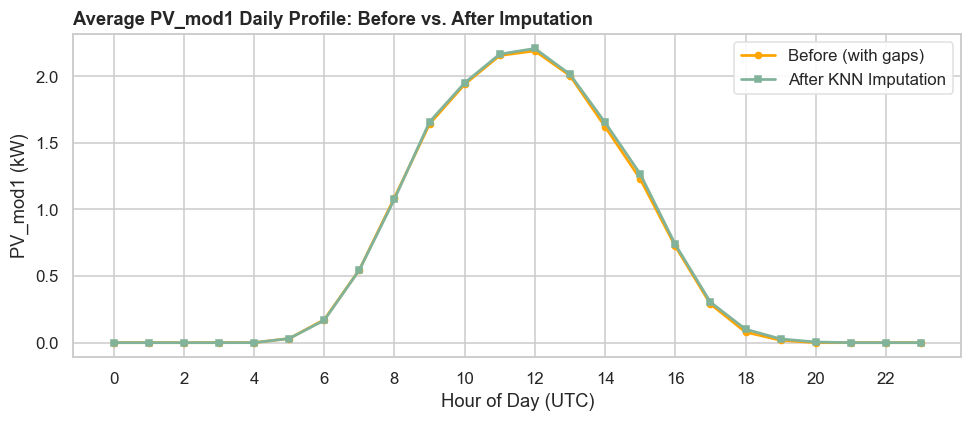

In [67]:
# Figure 4: Daily Profile Comparison (Before vs After)
# Calculate hourly averages to see the effect of imputation on daily patterns
# Use the index (timestamp) to group by hour
hourly_original = comparison['original'].groupby(comparison.index.hour).mean()
hourly_imputed = comparison['multivariate'].groupby(comparison.index.hour).mean()

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(hourly_original.index, hourly_original.values, label='Before (with gaps)', 
        color=COLORS['pv_mod1'], linewidth=1.8, marker='o', markersize=4)
ax.plot(hourly_imputed.index, hourly_imputed.values, label='After KNN Imputation', 
        color=COLORS['imputed_multivariate'], linewidth=1.8, marker='s', markersize=4)
ax.set_title('Average PV_mod1 Daily Profile: Before vs. After Imputation')
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('PV_mod1 (kW)')
ax.legend()
ax.set_xticks(range(0, 24, 2))
fig.tight_layout()

save_figure(fig, '04_daily_profiles')
plt.show()

## Summary statistics

In [68]:
# Compare imputation statistics
comparison_stats = comparison[['original', 'simple', 'univariate', 'multivariate']].agg(['mean', 'std', 'min', 'max']).T
comparison_stats['% missing'] = [original.isna().mean() * 100, 0, 0, 0]
comparison_stats = comparison_stats.round({'mean': 3, 'std': 3, 'min': 3, 'max': 3, '% missing': 2})
comparison_stats_path = TABLES_DIR / 'task4_imputation_summary.csv'
comparison_stats.to_csv(comparison_stats_path)

print("Imputation Statistics Comparison:")
display(comparison_stats)

Imputation Statistics Comparison:


,mean,std,min,max,% missing
original,0.657,1.103,0.0,4.81,5.0
simple,0.659,1.101,0.0,4.81,0.0
univariate,NaN,NaN,NaN,NaN,0.0
multivariate,0.663,1.110,0.0,4.81,0.0
